<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2 Assignment 2*

# Document Representations: Bag-Of-Words

In [1]:
import re
import string

!pip install -U nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import squarify
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


Requirement already up-to-date: nltk in /home/nedderlander/anaconda3/lib/python3.7/site-packages (3.4.4)


[nltk_data] Downloading package punkt to
[nltk_data]     /home/nedderlander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nedderlander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [2]:
df = pd.read_csv('job_listings.csv')
df.description.loc[0]

'b"<div><div>Job Requirements:</div><ul><li><p>\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them</p>\\n</li><li><p>Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)</p>\\n</li><li><p>Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R</p>\\n</li><li><p>Ability to communicate Model findings to both Technical and Non-Technical stake holders</p>\\n</li><li><p>Hands on experience in SQL/Hive or similar programming language</p>\\n</li><li><p>Must show past work via GitHub, Kaggle or any other published article</p>\\n</li><li><p>Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.</p></li></ul><div><div><div><div><div><d

## 2) Use Spacy to tokenize / clean the listings 

In [10]:
##### Your Code Here #####
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

custom_stops = ['<', '>', '\n', '"', '\\', '|', '</div>', '<ul>', '<li>', '<p>', 'li', 'ul', 'p', ']' , '\>']

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

#my tokenizer pipe w/stop word filter

def tokenize(series):
    tokens = []
    
    """ Tokenize while excluding stop words and punctuation """
    for doc in tokenizer.pipe(series, batch_size=500):
        
        doc_tokens = []
        
        for token in doc:   
            
            #skip stops and punctuation
            if (token.is_stop == False) and (token.is_punct == False):
                valid = True
                
                for stop in custom_stops:
                    if stop in token.text:
                        valid = False
                        break
                
            else:
                valid = False
                
            if valid == True:
                doc_tokens.append(token)
                
        tokens.append(doc_tokens)

    return tokens

df['spacy_tokens'] = tokenize(df['description'])

df.head()

,Unnamed: 0,description,title,spacy_tokens
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"[understanding, Machine, Learning, models, Bay..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"[Data, Scientist, 1,, build, machine, learning..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,"[Data, Scientist, working, business., analyzin..."
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"[$6,756, general, Professors, Dana, Mukamel, K..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,"[USA, years, Analytics, business, requirements..."


In [11]:
# now I'll visualize to get a sense of the number of stop words etc in the mix
# thank you jc for this function <3
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = list(zip(word_counts.keys(), word_counts.values()))
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = list(zip(appears_in.keys(), appears_in.values()))
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [12]:
wc = count(df['spacy_tokens'])
wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
7,understanding,1,1,1.0,0.000012,0.000012,0.002347
32,Machine,1,1,2.0,0.000012,0.000024,0.002347
23,Learning,1,1,3.0,0.000012,0.000036,0.002347
2,models,1,1,4.0,0.000012,0.000047,0.002347
15,"Bayes,",1,1,5.0,0.000012,0.000059,0.002347
46,"K-Means,",1,1,6.0,0.000012,0.000071,0.002347
38,"SVM,",1,1,7.0,0.000012,0.000083,0.002347
10,Linear/,1,1,8.0,0.000012,0.000095,0.002347
45,Logistic,1,1,9.0,0.000012,0.000107,0.002347
33,"Regression,",1,1,10.0,0.000012,0.000119,0.002347


# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [62]:
# create better custom stop words

BETTER_STOPS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
"yourselves", 'li', 'div', 'br', 'ul', 'xe2', 'x80', 'x99s', 'amp'])

In [64]:
##### Your Code Here #####
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(lowercase=True, stop_words=BETTER_STOPS)

In [65]:
# use the cv to create a document term matrix
dtm = cv.fit_transform(df['description'])


In [66]:
# Use count vectorizor to create a Document Term Matrice

# create a data frame with features and frequencey
dtm_df = pd.DataFrame(dtm.todense(), columns=cv.get_feature_names())
dtm_df.shape

(426, 9194)

# 4) Visualize the most common word counts

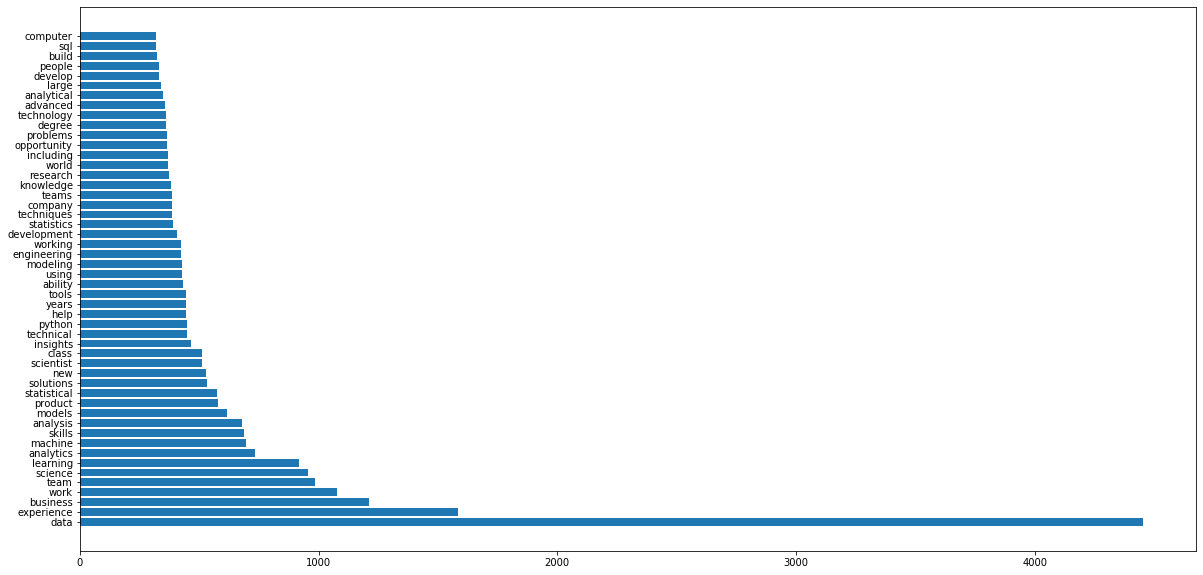

In [67]:
##### Your Code Here #####

top_50 = dtm_df.sum().sort_values(ascending=False)[:50]

fig, ax = plt.subplots(figsize=(20,10))
plt.barh(top_50.index, top_50.values)
plt.show()

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [17]:
df.head()

,Unnamed: 0,description,title,spacy_tokens
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"[understanding, Machine, Learning, models, Bay..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"[Data, Scientist, 1,, build, machine, learning..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,"[Data, Scientist, working, business., analyzin..."
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"[$6,756, general, Professors, Dana, Mukamel, K..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,"[USA, years, Analytics, business, requirements..."


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

#insantiate
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# create a vocab and get word counts per document

dtm = tfidf.fit_transform(df['description'])

# to view the matrix as a df:
docs = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())

In [23]:
docs.head()

,00,000,04,10,100,1079302,11,12,125,14,...,yes,yeti,york,young,yrs,zenreach,zeus,zf,zillow,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 # 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [24]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

# Fit on TF-IDF Vectors
nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [26]:
# Querry using my ideal data science job

ideal = """
We're looking for a junior data scientist who is interested in building on their knowledge and learning how to their skills to practical business problems. 

Our company values mentorship and employee development and a successful candidate will share those values. 
"""

ideal_job = tfidf.transform([ideal])

nn.kneighbors(ideal_job.todense())


(array([[1.30345556, 1.33864787, 1.33958878, 1.33958878, 1.34121317]]),
 array([[405, 130,  47, 100, 338]]))

In [35]:
# lets see these jobs
for job in df['description'].loc[[405, 130,  47, 100, 338]]:
    print(job + '\n')
#     print('\n')

b"<div>Data Scientist -<br/>\nDo you want the opportunity to leverage your skills to make a direct impact on the world\xe2\x80\x99s leading life sciences and consumer products companies? Join Clarkston Consulting as a Data Scientist to help deliver innovative business solutions to our market leading clients as a part of an expert team.<br/>\n<br/>\nWe are looking for motivated, self-driven leaders who are energized by team success and interested in joining a firm that values its culture and people as its biggest strengths. Together, we can help find the answers to our clients most challenging business problems.<br/>\n<br/>\nWhat You\xe2\x80\x99ll Do<br/>\nClarkston gives you the opportunity to deliver great solutions, become recognized as an industry expert, and help build a great practice.<br/>\n<br/>\nAs a Data Specialist at Clarkston you will:<br/>\n<ul><li>Conduct exploratory analysis, produce descriptive statistics and explain phenomena based on data</li><li>Develop statistical an

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.